<a href="https://colab.research.google.com/github/dave502/computer_vision/blob/main/segmentation%20with%20U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
import os
from google.colab import drive
drive.mount('/content/drive')

# метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)

Mounted at /content/drive


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/MLData/kaggle.json' ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
# !rm -rf /content/cityscapes_data/

In [ ]:
! kaggle datasets download dansbecker/cityscapes-image-pairs --unzip 

 90% 181M/202M [00:01<00:00, 104MB/s]
100% 202M/202M [00:01<00:00, 134MB/s]


In [ ]:
# переменные путей к изображениям
PAHT_images = '/content/cityscapes_data/train/'
PAHT_val_images = '/content/cityscapes_data/val/'
# списки имён файлов тренировочных и тестовых
images_names = os.listdir(PAHT_images)
images_val_names = os.listdir(PAHT_val_images)

In [ ]:
# преобразование тестового изображения в numpy массив и разделение его на оригинальное изображение и сегментированное
np_val_images_masks = [cv2.imread(PAHT_val_images+filename) for filename in images_val_names]
np_val_images_masks = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in np_val_images_masks])
tuple_val_images_masks = np.array([(image[:, :256,], image[:, 256:]) for image in np_val_images_masks]) 
val_images = tuple_val_images_masks[:,0]
val_masks = tuple_val_images_masks[:,1]

In [ ]:
class Generator(tf.keras.utils.Sequence):
  def __init__(self, batch_size, images_path, images_names, classes_num, samples=0):
       """
       batch_size - количство возвращаемых единовременно изображений
       images_path - путь к каталогу с изображениями
       images_names - имена изображений
       classes_num - количество классов объектов в изображении
       samples - ограничение количества изображений из каталога (не используется)
       """
       super(Generator, self).__init__()
       self.images_path = images_path
       self.images_names = images_names if samples==0 else images_names[:samples]
       self.batch_size = batch_size
       self.classes_num = classes_num
       self.current_step = 0
       self.kmeans = None
       self.available_steps = int(len(images_names) // self.batch_size)

  def generate_batch(self):
       start = self.current_step * self.batch_size
       stop = (self.current_step + 1) * self.batch_size

       # получение файлов и пребразование в numpy массив 
       np_images = [cv2.imread(PAHT_images+filename) for filename in images_names[start:stop]]
       np_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in np_images])

       # разделение изображение на самоизображение и сегментированное изображение 
       images_tuple = np.array([(image[:, :256,], image[:, 256:]) for image in np_images]) 

       original_images = images_tuple[:, 0]
       segments_images = images_tuple[:, 1]
        
       # преобразование сегментированного изображения из 3D в 2D для кластеризации 
       segments_img2D = segments_images.reshape((segments_images.shape[0]*segments_images.shape[1]*segments_images.shape[2], 3))

       # обучение кластеризатора (один раз на первом батче для ускорения работы)

       # если будут использоваться батчи малых размеров, нужно будет выносить обучение 
       # kmeans в отдельную функцию класса, чтобы было достаточно данных для обучения
       # и обучать kmeans отдельно, перед использованием генератора 

       if not self.kmeans:
          self.kmeans = KMeans(n_clusters = self.classes_num)
          self.kmeans.fit(segments_img2D)

       # преобразование цветов изображения в индексы
       masks = np.vstack([[self.__Color2index(image) for image in segments_images]])  

       # возвращение оригинальных картинок и закодированных
       return original_images, masks

  def __Color2index(self, image):
      """
      преобразование цветов изображения в индексы
      """ 

      reshaped_image = image.reshape(image.shape[0]*image.shape[1], 3)

      # заготовка для индексов
      cats = np.eye(self.classes_num)

      # кластеризация изображения
      labels = self.kmeans.predict(reshaped_image)

      # преобразование цветов в индексы
      cat_image = np.array(cats)[labels]

      # восстановление размерности изображения
      cat_image = cat_image.reshape(image.shape[0], image.shape[1], self.classes_num) 
      
      return cat_image

  def __getitem__(self, index):
        
        self.current_step = index
        images, masks = self.generate_batch()
        return images, masks

  def __len__(self):
        return self.available_steps

In [ ]:
num_classes = 12

In [ ]:
def Unet(num_classes = 12, input_shape= (256, 256, 3)):
  #num_classes - число классов ответа
  #input_shape - размер входной картинки

  #model - выходная модель

    img_input = Input(input_shape) # вход модели

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [ ]:
model = Unet(12)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [ ]:
# обучение модели
train_generator = Generator(images_path=PAHT_images, images_names=images_names, batch_size=10, classes_num=12)
test_generator = Generator(images_path=PAHT_images, images_names=images_names, batch_size=10, classes_num=12)
history = model.fit(train_generator, validation_data = train_generator, epochs = 30)

Epoch 1/30
297/297 [==============================] - 255s 793ms/step - loss: 0.9260 - dice_coef: 0.6019 - val_loss: 1.4619 - val_dice_coef: 0.5497
Epoch 2/30
297/297 [==============================] - 236s 794ms/step - loss: 0.7041 - dice_coef: 0.6936 - val_loss: 0.8247 - val_dice_coef: 0.7191
Epoch 3/30
297/297 [==============================] - 236s 796ms/step - loss: 0.6364 - dice_coef: 0.7231 - val_loss: 0.7003 - val_dice_coef: 0.7415
Epoch 4/30
297/297 [==============================] - 237s 798ms/step - loss: 0.5835 - dice_coef: 0.7447 - val_loss: 0.6811 - val_dice_coef: 0.7230
Epoch 5/30
297/297 [==============================] - 236s 796ms/step - loss: 0.5559 - dice_coef: 0.7558 - val_loss: 0.6084 - val_dice_coef: 0.7433
Epoch 6/30
297/297 [==============================] - 237s 797ms/step - loss: 0.5312 - dice_coef: 0.7658 - val_loss: 0.6475 - val_dice_coef: 0.7567
Epoch 7/30
297/297 [==============================] - 237s 797ms/step - loss: 0.5092 - dice_coef: 0.7748 - val_l

In [ ]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://6590fb97-b9b1-473a-99bf-ec607215a7b6/assets


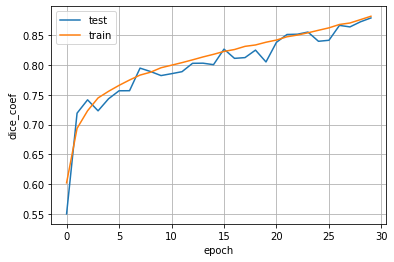

In [ ]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.show()

видно, что модель можно ещё дообучить, увеличив количество эпох, но это займёт продолжительное время

Выполним разметку некоторых тестовых изображений с помощью полученной модели

In [ ]:
# для примера возьмём 6 изобаржений
samples = 6
pred = model.predict(val_images[:samples])
print(pred.shape)

(6, 256, 256, 12)


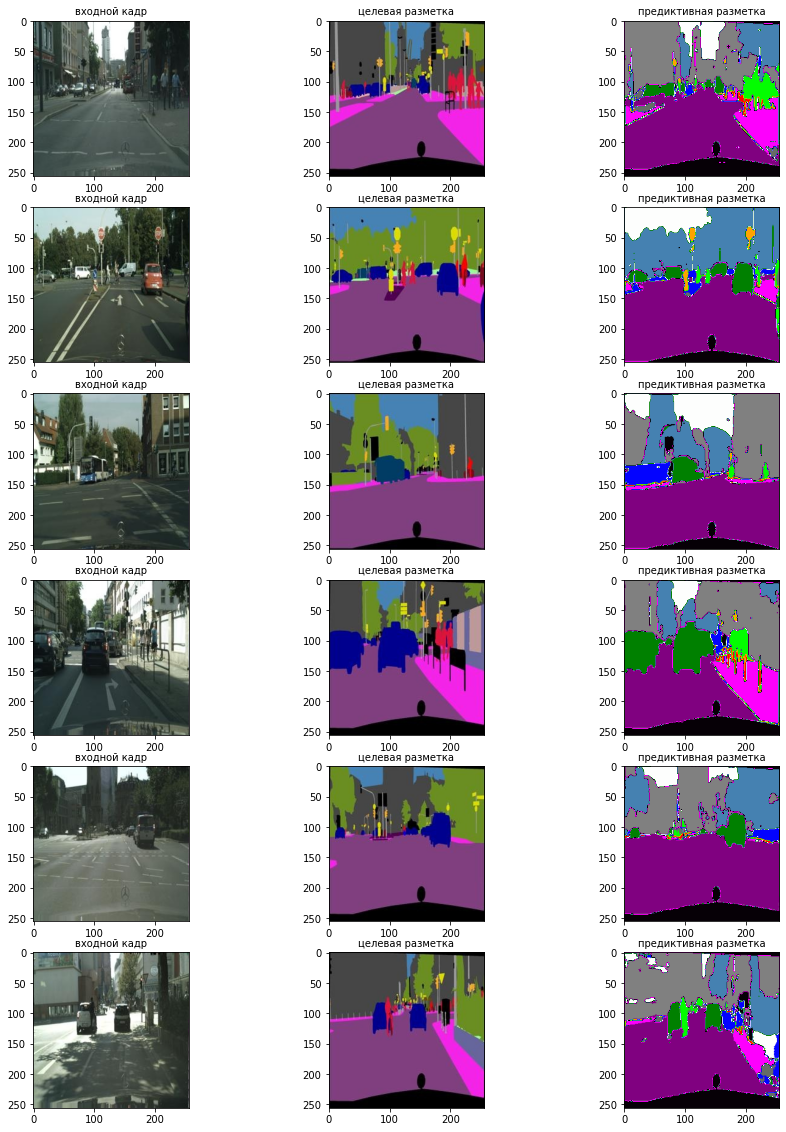

In [ ]:
# вывод на экран полученного результата
import matplotlib as mpl
# цвета для вывода результата (они не будут совпадать с тестовым сегментированным изображением)
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', \
     ['grey', 'purple', 'magenta', 'black', 'steelblue', 'green', 'white','blue', 'dimgray', 'lime', 'orange', 'red'], 256)

fig, ax = plt.subplots(samples, 3,figsize=(15,20))

for i in range(samples):
  ax[i, 0].imshow(val_images[i])
  ax[i, 0].set_title('входной кадр', fontdict={'fontsize': 10, 'fontweight': 'medium'})

  ax[i, 1].imshow(val_masks[i])
  ax[i, 1].set_title('целевая разметка', fontdict={'fontsize': 10, 'fontweight': 'medium'})

  img = pred[i].argmax(axis=2)
  ax[i, 2].imshow(img.astype(float), cmap=cmap1)
  ax[i, 2].set_title('предиктивная разметка', fontdict={'fontsize': 10, 'fontweight': 'medium'})

plt.show()

Результат можно считать удовлетворительным, почти все объекты были определены. Результат можно было бы улучшить повышением количества эпох, а также, возможно, использованием аугементации

P.S. Сюда не вошёл код из черновика с определением количества классов, поэтому он будет здесь и на тестовом наборе (изначально, был на обучающем):

In [ ]:
samples_num = 50 # для обнаружения классов возьмём 50 картинок
segments_img = val_masks[:samples_num]
segments_pxs = segments_img.reshape((samples_num*segments_img.shape[1]*segments_img.shape[2],3))

In [ ]:
segments_img.shape

(50, 256, 256, 3)

In [ ]:
# получаем список цветов всех пикселей, имеющихся в образцах
segments_pxs = segments_img.reshape((samples_num*segments_img.shape[1]*segments_img.shape[2],3))

In [ ]:
wcss=[]
class_num = 15 # стартовое предполагаемое значение количества классов
for i in range(1,class_num):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(segments_pxs)
  wcss.append(kmeans.inertia_)

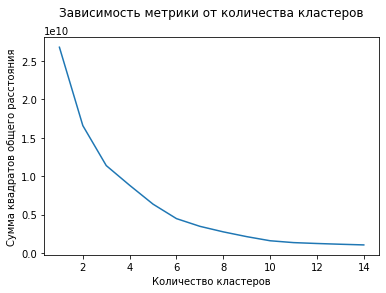

In [ ]:
plt.plot(range(1,class_num),wcss)
plt.title('Зависимость метрики от количества кластеров\n')
plt.xlabel("Количество кластеров")
plt.ylabel("Сумма квадратов общего расстояния")
plt.show()

Таким образом, можно принять количество классов равным 12